# 4.1. Linear regression

## Environment setup

### Install TGL package

In [185]:
import os

In [186]:
os.environ['PATH'] = "/Users/ivandonofrio/Workplace/Notebooks/venv/bin:" + os.environ['PATH']

In [187]:
%%sh
git clone git@github.com:donofiva/TemporalGraphLearning.git
cd TemporalGraphLearning
pip install .
cd ..
rm -r TemporalGraphLearning

Cloning into 'TemporalGraphLearning'...


Processing /Users/ivandonofrio/Workplace/Notebooks/TemporalGraphLearning
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for temporal_graph_learning: filename=temporal_graph_learning-0.0.1-py3-none-any.whl size=13162 sha256=be7e8aa3219fa4889e1401e2fa7d5b0d1e9b5b49c52868fa534cf7e064eaf17f
  Stored in directory: /private/var/folders/qv/mvb8szpn0zgfn8vn02k7c24m0000gn/T/pip-ephem-wheel-cache-1a6gbswq/wheels/39/db/05/f395aacb8d67d0f880772d6a24131398880b7ba726b6f1820e
Successfully built temporal_graph_learning
  Attempting uninstall: temporal_graph_learning
    Found existing installation: tempo

### Install dependencies

In [188]:
!pip install numpy

In [189]:
!pip install scipy

In [190]:
!pip install pandas

In [191]:
!pip install matplotlib

In [192]:
!pip install seaborn

In [193]:
!pip install scikit-learn

### Define constants and configurations

In [194]:
INPUT_PATH = 'inputs'

## Dependencies

In [195]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
from temporal_graph_learning.abstraction.Dataset import Dataset
from temporal_graph_learning.abstraction.Timeseries import Timeseries
from temporal_graph_learning.charts.Plots import Plots
from temporal_graph_learning.charts.Plot import Plot
from temporal_graph_learning.charts.Histogram import Histogram
from temporal_graph_learning.charts.Lineplot import Lineplot
from temporal_graph_learning.charts.IdentityLine import IdentityLine
from temporal_graph_learning.charts.Heatmap import Heatmap
from temporal_graph_learning.charts.Scatterplot import Scatterplot
from temporal_graph_learning.charts.Text import Text
from temporal_graph_learning.charts.AutoCorrelation import AutoCorrelation
from temporal_graph_learning.io.FileManager import FileManager
from temporal_graph_learning.data.impute.LinearInterpolationImputer import LinearInterpolationImputer
from temporal_graph_learning.models.MultiTargetLinearRegression import MultiTargetLinearRegression

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [198]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

## Read data

In [228]:
timeseries = pd.read_csv('inputs/timeseries_outliers.csv')

In [229]:
timeseries = timeseries[timeseries.TURBINE == 1]

## Processing

In [230]:
timeseries = timeseries.dropna(ignore_index=True)

In [231]:
timeseries = timeseries.drop(columns=['TURBINE', 'DAY', 'TIMESLOT'])

## Training

In [232]:
X = timeseries.drop(columns=['ACTIVE_POWER'])

In [233]:
y = timeseries['ACTIVE_POWER']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, shuffle=True)

In [235]:
pipeline = Pipeline([
    ('regressor', LinearRegression())
])

In [236]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('regressor', LinearRegression())])

In [237]:
y_hat = pipeline.predict(X_test)

## Residuals plot

In [238]:
residual_scatterplot = Scatterplot(opacity=0.05)
identity_line = IdentityLine()

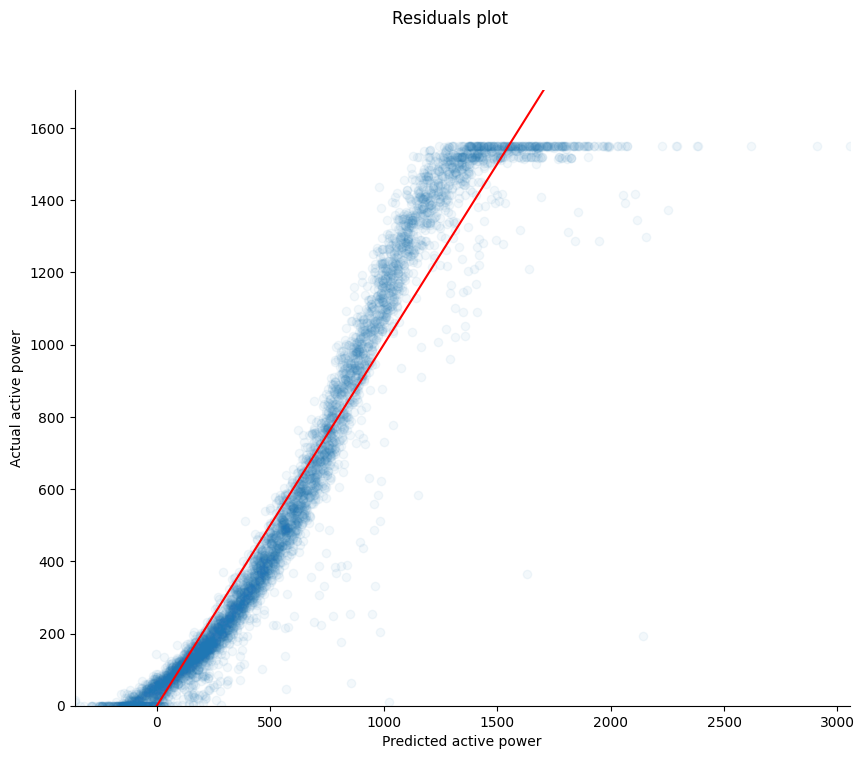

In [239]:
# Initialize plots
plots = Plots(1, 1, 10, 8)
plot = plots.get_plot_from_list_by_index(0)

# Draw scatterplot
identity_line.draw_on_plot(plot)
residual_scatterplot.draw_on_plot(
    y_hat,
    y_test.values,
    plot
)

# Configure plot
plot.toggle_top_and_right_border(False)
plot.set_x_axis_boundaries(y_hat.min(), y_hat.max())
plot.set_y_axis_boundaries(y_test.values.min(), y_test.values.max() * 1.1)
plot.set_axis_labels('Predicted active power', 'Actual active power')
plots.set_title('Residuals plot')

# Show plots
plots.show()
del plot

## Feature importance

In [240]:
feature_to_feature_importance = dict(
    zip(
        X_train.columns,
        pipeline.named_steps['regressor'].coef_
    )
)

In [241]:
feature_to_feature_importance = pd.DataFrame(
    feature_to_feature_importance.items(), 
    columns=['DIMENSION', 'WEIGHT']
)

feature_to_feature_importance.sort_values('WEIGHT', ignore_index=True)

,DIMENSION,WEIGHT
0,PITCH_ANGLE_SECOND_BLADE,-157.958598
1,EXTERNAL_TEMPERATURE,-6.070475
2,NACELLE_DIRECTION,0.008764
3,REACTIVE_POWER,0.345136
4,WIND_DIRECTION,0.421014
5,INTERNAL_TEMPERATURE,8.005012
6,PITCH_ANGLE_THIRD_BLADE,71.559044
7,PITCH_ANGLE_FIRST_BLADE,78.913904
8,WIND_SPEED,146.016415


## Validation

In [242]:
cross_validation = cross_validate(
    pipeline,
    X,
    y,
    cv=KFold(shuffle=True),
    scoring=[
        'neg_mean_absolute_error',
        'neg_root_mean_squared_error',
        'r2'
    ]
)

In [243]:
pd.DataFrame(cross_validation)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2
0,0.032229,0.014189,-99.979042,-140.634915,0.927071
1,0.124910,0.007121,-102.427349,-146.813152,0.921531
2,0.135734,0.030750,-101.148296,-145.441612,0.920824
3,0.223101,0.035714,-98.844634,-133.111511,0.933969
4,0.089548,0.009489,-101.109422,-140.443416,0.929039
